### Transformer Encoder(Only)

In [1]:
import os
import random, time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Fix seeds
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("CUDA available? ", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Current device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_properties(0).name)

CUDA available?  True
Device count: 1
Current device: 0
Device name: NVIDIA GeForce RTX 5070


In [2]:
import os, glob, time, random
import numpy as np
import torch, torch.nn as nn, torch.optim as optim

# ─── 하이퍼파라미터 ─────────────────────────────────────────────────────────
EMB_DIM     = 128    # 토큰 임베딩 차원
N_HEADS     = 8      # self-attention 헤드 수
N_LAYERS    = 3      # Transformer 인코더 레이어 수
DROPOUT     = 0.1    # 드롭아웃
BATCH_SIZE  = 128    # 리플레이 배치 크기
LR          = 1e-4   # 학습률
GAMMA       = 0.99   # 할인율
EPS_START   = 1.0    # 초기 ε
EPS_END     = 0.05   # 최소 ε
EPS_DECAY   = 0.995  # ε 감쇠율
SYNC_STEPS  = 500    # 타겟 네트워크 동기화 스텝
EPISODES    = 5000   # Distribution-based 에피소드 수

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}\n")

Using device: cuda



In [4]:
import os, glob, time, random
import numpy as np
import torch, torch.nn as nn, torch.optim as optim

# ─── 하이퍼파라미터 ─────────────────────────────────────────────────────────
EMB_DIM     = 128    # 토큰 임베딩 차원
N_HEADS     = 8      # self-attention 헤드 수
N_LAYERS    = 3      # Transformer 인코더 레이어 수
DROPOUT     = 0.1    # 드롭아웃
BATCH_SIZE  = 128    # 리플레이 배치 크기
LR          = 1e-4   # 학습률
GAMMA       = 0.99   # 할인율
EPS_START   = 1.0    # 초기 ε
EPS_END     = 0.05   # 최소 ε
EPS_DECAY   = 0.995  # ε 감쇠율
SYNC_STEPS  = 500    # 타겟 네트워크 동기화 스텝
EPISODES    = 5000   # Distribution-based 에피소드 수

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}\n")

# ─── 1. 데이터 로드 ─────────────────────────────────────────────────────────
# 1.1 훈련 인스턴스 (500 npz)
train_files  = sorted(glob.glob("data/TSP20/instances/instance_*.npz"))
train_coords = [np.load(f)["coords"].astype(np.float32) for f in train_files]

# 1.2 테스트 5개 (txt)
def load_test(path):
    coords_list, tours = [], []
    with open(path) as f:
        for line in f:
            parts = line.strip().split()
            i = parts.index("output")
            coords = np.array(list(map(float, parts[:i])), dtype=np.float32).reshape(-1,2)
            tour   = [int(x)-1 for x in parts[i+1:]]  # 0-based
            coords_list.append(coords)
            tours.append(tour)
    return coords_list, tours

test_coords, test_tours = load_test("data/homework/hw_2_tsp_20.txt")
N = train_coords[0].shape[0]  # 도시 수
print(f"Loaded {len(train_coords)} train instances, {len(test_coords)} test instances, N={N}\n")

# ─── 2. Token-based Environment ───────────────────────────────────────────────
class TSPEnvToken:
    def __init__(self, coords):
        self.coords = coords
        self.N = len(coords)
        self.reset()
    def reset(self):
        self.visited = np.zeros(self.N, bool)
        self.current = 0
        self.visited[0] = True
        return self._state()
    def _state(self):
        # (N,4) 토큰 시퀀스: [x,y,visited,is_current]
        xy = self.coords.astype(np.float32)
        visited = self.visited.astype(np.float32)[:,None]
        is_cur   = np.eye(self.N, dtype=np.float32)[self.current][:,None]
        return np.concatenate([xy, visited, is_cur], axis=1)
    def step(self, a):
        prev = self.current
        self.current = a
        self.visited[a] = True
        dist = np.linalg.norm(self.coords[prev] - self.coords[a])
        r = -dist
        done = self.visited.all()
        if done:
            # 출발점으로 돌아가는 거리 패널티
            r -= np.linalg.norm(self.coords[self.current] - self.coords[0])
        return self._state(), r, done, {}

# ─── 3. Transformer-DQN 네트워크 ─────────────────────────────────────────────
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe)
    def forward(self, x):
        # x.shape = (B, N, d_model)
        return x + self.pe[:x.size(1)].unsqueeze(0)

class TSPTransformerDQN(nn.Module):
    def __init__(self, emb_dim, n_heads, n_layers, dropout):
        super().__init__()
        self.input_proj = nn.Linear(4, emb_dim)
        self.pos_enc    = PositionalEncoding(emb_dim, max_len=N)
        layer = nn.TransformerEncoderLayer(
            d_model=emb_dim, nhead=n_heads, dropout=dropout, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(layer, n_layers)
        self.q_head  = nn.Linear(emb_dim, 1)
    def forward(self, tokens):
        # tokens: (B, N, 4)
        x = self.input_proj(tokens)        # (B, N, emb_dim)
        x = self.pos_enc(x)                # (B, N, emb_dim)
        x = self.encoder(x)                # (B, N, emb_dim)
        q = self.q_head(x).squeeze(-1)     # (B, N)
        return q

# ─── 4. Replay Buffer & Agent ───────────────────────────────────────────────
class ReplayBuffer:
    def __init__(self, cap=20000):
        self.buf = []
        self.cap = cap
    def push(self, *exp):
        if len(self.buf) >= self.cap:
            self.buf.pop(0)
        self.buf.append(exp)
    def sample(self, B):
        idx = random.sample(range(len(self.buf)), B)
        s,a,r,s2,d = zip(*(self.buf[i] for i in idx))
        return (
            torch.tensor(np.stack(s), dtype=torch.float32, device=DEVICE),
            torch.tensor(a, dtype=torch.long,   device=DEVICE),
            torch.tensor(r, dtype=torch.float32,device=DEVICE),
            torch.tensor(np.stack(s2), dtype=torch.float32,device=DEVICE),
            torch.tensor(d, dtype=torch.float32,device=DEVICE)
        )
    def __len__(self): return len(self.buf)

class DQNAgent:
    def __init__(self):
        self.net    = TSPTransformerDQN(EMB_DIM, N_HEADS, N_LAYERS, DROPOUT).to(DEVICE)
        self.target = TSPTransformerDQN(EMB_DIM, N_HEADS, N_LAYERS, DROPOUT).to(DEVICE)
        self.target.load_state_dict(self.net.state_dict())
        self.opt    = optim.Adam(self.net.parameters(), lr=LR)
        self.buf    = ReplayBuffer()
        self.gamma  = GAMMA
        self.steps  = 0

    def select(self, state, eps):
        # state: np (N,4) → torch (1,N,4)
        feat = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        visited_mask = state[:,2]  # 1=visited, 0=unvisited
        if random.random() < eps:
            candidates = np.where(visited_mask == 0)[0]
            return int(random.choice(candidates))
        with torch.no_grad():
            q = self.net(feat)[0].cpu().numpy()
        q[visited_mask>0] = -np.inf
        return int(np.argmax(q))

    def update(self):
        if len(self.buf) < BATCH_SIZE:
            return
        s,a,r,s2,d = self.buf.sample(BATCH_SIZE)
        # Q(s,a)
        q_s = self.net(s).gather(1, a.unsqueeze(1)).squeeze(1)
        # target Q
        with torch.no_grad():
            q2 = self.target(s2).max(1)[0]
            y  = r + self.gamma * q2 * (1 - d)
        loss = nn.SmoothL1Loss()(q_s, y)
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
        # 타겟 네트워크 동기화
        self.steps += 1
        if self.steps % SYNC_STEPS == 0:
            self.target.load_state_dict(self.net.state_dict())

# ─── 5. Distribution-Based 학습 루프 ───────────────────────────────────────
agent = DQNAgent()
eps   = EPS_START
history = []
start_time = time.time()

print("=== Start Distribution-Based Training ===")
for ep in range(1, EPISODES+1):
    coords = random.choice(train_coords)
    env    = TSPEnvToken(coords)
    s      = env.reset()
    done   = False
    total_r = 0.0

    while not done:
        a = agent.select(s, eps)
        s2, r, done, _ = env.step(a)
        agent.buf.push(s, a, r, s2, float(done))
        s, total_r = s2, total_r + r
        agent.update()

    history.append(total_r)
    eps = max(EPS_END, eps * EPS_DECAY)

    # 100 에피소드마다 로그 출력
    if ep % 1000 == 0 or ep == 1:
        avg100 = np.mean(history[-100:]) if len(history) >= 100 else history[-1]
        elapsed = time.time() - start_time
        print(f"Ep {ep:4d}/{EPISODES}  ε={eps:.3f}  avg100={avg100:6.2f}  elapsed={elapsed:5.1f}s")

print(f"\nTraining completed in {time.time()-start_time:.1f}s\n")

# ─── 6. 5개 인스턴스 평가 ─────────────────────────────────────────────────
print("=== Test on 5 Instances ===")
for i, (coords, tour) in enumerate(zip(test_coords, test_tours), start=1):
    env  = TSPEnvToken(coords)
    s    = env.reset()
    done = False
    route = [env.current]

    while not done:
        a = agent.select(s, eps=0.0)
        s, _, done, _ = env.step(a)
        route.append(a)
    route.append(0)  # 출발점 복귀

    # 최적해 비용 계산
    opt_cycle = tour + [tour[0]]
    opt_cost  = sum(np.linalg.norm(coords[u]-coords[v])
                    for u,v in zip(opt_cycle[:-1],opt_cycle[1:]))
    dqncost   = sum(np.linalg.norm(coords[route[j]]-coords[route[j+1]])
                    for j in range(len(route)-1))
    gap = (dqncost - opt_cost)/opt_cost * 100

    print(f"\n-- Test {i} --")
    print(f"Optimal route = {[n+1 for n in opt_cycle]}")
    print(f"DQN     route = {[n+1 for n in route]}")
    print(f"Optimal cost = {opt_cost:.4f}")
    print(f"DQN cost     = {dqncost:.4f}")
    print(f"Gap (%)      = {gap:.2f}%")

Using device: cuda

Loaded 500 train instances, 5 test instances, N=20

=== Start Distribution-Based Training ===
Ep    1/5000  ε=0.995  avg100= -9.27  elapsed=  0.0s
Ep  100/5000  ε=0.606  avg100= -9.61  elapsed= 18.2s
Ep  200/5000  ε=0.367  avg100= -7.78  elapsed= 38.7s
Ep  300/5000  ε=0.222  avg100= -6.65  elapsed= 60.7s
Ep  400/5000  ε=0.135  avg100= -6.22  elapsed= 82.5s
Ep  500/5000  ε=0.082  avg100= -5.69  elapsed=103.0s
Ep  600/5000  ε=0.050  avg100= -5.33  elapsed=125.2s
Ep  700/5000  ε=0.050  avg100= -5.23  elapsed=147.6s
Ep  800/5000  ε=0.050  avg100= -4.97  elapsed=170.0s
Ep  900/5000  ε=0.050  avg100= -5.04  elapsed=192.5s
Ep 1000/5000  ε=0.050  avg100= -5.03  elapsed=213.9s
Ep 1100/5000  ε=0.050  avg100= -5.01  elapsed=235.8s
Ep 1200/5000  ε=0.050  avg100= -4.92  elapsed=258.0s
Ep 1300/5000  ε=0.050  avg100= -4.81  elapsed=280.9s
Ep 1400/5000  ε=0.050  avg100= -4.73  elapsed=303.4s
Ep 1500/5000  ε=0.050  avg100= -4.78  elapsed=324.7s
Ep 1600/5000  ε=0.050  avg100= -4.77  

In [3]:
# 2) 환경, 데이터 불러온 리스트 등 큰 객체 해제
del env
del train_coords

# 3) GPU 캐시 비우기
import torch
torch.cuda.empty_cache()

# ─── (C) 실험 이름 생성 ─────────────────────────────────────────────────
exp_name = (
    f"TSDQN_Trans_L{N_LAYERS}_H{EMB_DIM}_Hd{N_HEADS}"
    f"_BS{BATCH_SIZE}_LR{LR:.0e}_G{GAMMA}_Eps{EPS_DECAY:.3f}"
)

# ─── (D) 결과 디렉터리 준비 ─────────────────────────────────────────────
import os; os.makedirs("results", exist_ok=True)

# ─── (E) 보상 기록 저장 (.npy) ───────────────────────────────────────────
rewards_path = os.path.join("results", f"{exp_name}_dist_rewards.npy")
np.save(rewards_path, np.array(history, dtype=np.float32))
print(f"✔ Saved rewards to '{rewards_path}'")

# ─── (F) 모델 체크포인트 저장 (.pth) ────────────────────────────────────
ckpt_path = os.path.join("results", f"{exp_name}_model.pth")
torch.save(agent.net.state_dict(), ckpt_path)
print(f"✔ Saved model checkpoint to '{ckpt_path}'")

# ─── (G) 시각화를 위한 history 복사 & 객체 해제 ─────────────────────────
# history 리스트가 GPU에 올린 적은 없지만, 안전을 위해 numpy 로 복사
hist_cpu = np.array(history, dtype=np.float32)
del history
torch.cuda.empty_cache()

# ─── (H) 러닝 커브 플롯 저장 & 표시 ─────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

plt.figure(figsize=(10, 6))
sns.lineplot(data=hist_cpu, color='royalblue')
plt.title(f"{exp_name} Learning Curve", fontsize=16)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total Reward", fontsize=14)
formatter = ticker.FuncFormatter(lambda x, pos: f"{x:,.0f}")
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().set_facecolor('#F2F2F2')
plt.grid(axis='y', color='white', linestyle='--', linewidth=1)

fig_path = os.path.join("results", f"{exp_name}_learning_curve.png")
plt.tight_layout()
plt.savefig(fig_path)
print(f"✔ Saved learning curve to '{fig_path}'")

NameError: name 'history' is not defined

In [ ]:
import os, glob, time, random
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# ─── 하이퍼파라미터 ─────────────────────────────────────────────────────────
EMB_DIM     = 128
N_HEADS     = 8
N_LAYERS    = 3
DROPOUT     = 0.1
BATCH_SIZE  = 64
LR          = 1e-4
GAMMA       = 0.99
EPS_START   = 1.0
EPS_END     = 0.05
EPS_DECAY   = 0.995
SYNC_STEPS  = 500
STAGE_EPS   = 10000

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}\n")

# ─── 1. 데이터 로드 ─────────────────────────────────────────────────────────
def load_coords(n):
    files = sorted(glob.glob(f"data/TSP{n}/instances/instance_*.npz"))
    return [np.load(f)["coords"].astype(np.float32) for f in files]

train_10 = load_coords(10)
train_20 = load_coords(20)
train_30 = load_coords(30)

def load_test(path="data/homework/hw_2_tsp_20.txt"):
    coords_list, tours = [], []
    with open(path) as f:
        for line in f:
            parts = line.strip().split(); i = parts.index("output")
            vals = list(map(float, parts[:i]))
            tour = [int(x)-1 for x in parts[i+1:]]
            coords_list.append(np.array(vals, dtype=np.float32).reshape(-1,2))
            tours.append(tour)
    return coords_list, tours

test_coords, test_tours = load_test()
print(f"Loaded test {len(test_coords)} instances (20 cities each)\n")

# ─── 2. Token-based Env ───────────────────────────────────────────────────────
class TSPEnvToken:
    def __init__(self, coords, N_max):
        self.coords = coords; self.N = len(coords); self.N_max = N_max
    def reset(self):
        self.visited = np.zeros(self.N, bool)
        self.current = 0; self.visited[0] = True
        return self._state()
    def _state(self):
        xy      = self.coords.astype(np.float32)
        visited = self.visited.astype(np.float32)[:,None]
        is_cur  = np.eye(self.N, dtype=np.float32)[self.current][:,None]
        tokens  = np.concatenate([xy, visited, is_cur], axis=1)
        if self.N < self.N_max:
            pad = np.zeros((self.N_max-self.N,4), np.float32)
            pad[:,2] = 1.0  # 강제 방문 처리
            tokens = np.vstack([tokens, pad])
        return tokens
    def step(self, a):
        prev = self.current; self.current = a; self.visited[a] = True
        dist = np.linalg.norm(self.coords[prev]-self.coords[a])
        r = -dist
        done = bool(self.visited.all())
        if done:
            r -= np.linalg.norm(self.coords[self.current] - self.coords[0])
        return self._state(), r, done, {}

# ─── 3. Transformer-DQN ───────────────────────────────────────────────────────
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0)/d_model))
        pe[:,0::2], pe[:,1::2] = torch.sin(pos*div), torch.cos(pos*div)
        self.register_buffer('pe', pe)
    def forward(self, x):
        return x + self.pe[:x.size(1)].unsqueeze(0)

class TSPTransformerDQN(nn.Module):
    def __init__(self, emb_dim, n_heads, n_layers, dropout, max_len):
        super().__init__()
        self.input_proj = nn.Linear(4, emb_dim)
        self.pos_enc    = PositionalEncoding(emb_dim, max_len)
        layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=n_heads,
                                           dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(layer, n_layers)
        self.q_head  = nn.Linear(emb_dim,1)
    def forward(self, tokens):
        x = self.input_proj(tokens)
        x = self.pos_enc(x)
        x = self.encoder(x)
        return self.q_head(x).squeeze(-1)

# ─── 4. Buffer & Agent ───────────────────────────────────────────────────────
class ReplayBuffer:
    def __init__(self, cap=10000): self.buf, self.cap = [], cap
    def push(self,*exp):
        if len(self.buf)>=self.cap: self.buf.pop(0)
        self.buf.append(exp)
    def sample(self,B):
        idx = random.sample(range(len(self.buf)), B)
        s,a,r,s2,d = zip(*(self.buf[i] for i in idx))
        return (
            torch.tensor(np.stack(s), dtype=torch.float32, device=DEVICE),
            torch.tensor(a, dtype=torch.long, device=DEVICE),
            torch.tensor(r, dtype=torch.float32, device=DEVICE),
            torch.tensor(np.stack(s2), dtype=torch.float32, device=DEVICE),
            torch.tensor(d, dtype=torch.float32, device=DEVICE),
        )
    def __len__(self): return len(self.buf)

class DQNAgent:
    def __init__(self, max_len):
        self.net    = TSPTransformerDQN(EMB_DIM,N_HEADS,N_LAYERS,DROPOUT,max_len).to(DEVICE)
        self.target = TSPTransformerDQN(EMB_DIM,N_HEADS,N_LAYERS,DROPOUT,max_len).to(DEVICE)
        self.target.load_state_dict(self.net.state_dict())
        self.opt    = optim.Adam(self.net.parameters(), lr=LR)
        self.buf    = ReplayBuffer()
        self.gamma  = GAMMA
        self.steps  = 0
    def select(self, state, eps):
        feat    = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        visited = state[:,2]
        if random.random()<eps:
            candidates = np.where(visited==0)[0]
            return int(random.choice(candidates))
        with torch.no_grad():
            q = self.net(feat)[0].cpu().numpy()
        q[visited>0] = -np.inf
        return int(np.argmax(q))
    def update(self):
        if len(self.buf)<BATCH_SIZE: return
        s,a,r,s2,d = self.buf.sample(BATCH_SIZE)
        q_s = self.net(s).gather(1,a.unsqueeze(1)).squeeze(1)
        with torch.no_grad():
            q2 = self.target(s2).max(1)[0]
            y  = r + self.gamma*q2*(1-d)
        loss = nn.SmoothL1Loss()(q_s,y)
        self.opt.zero_grad(); loss.backward(); self.opt.step()
        self.steps+=1
        if self.steps%SYNC_STEPS==0:
            self.target.load_state_dict(self.net.state_dict())

# ─── 5. 커리큘럼 학습 ───────────────────────────────────────────────────────
curriculum = [
    ([10],         STAGE_EPS),
    ([10,20],      STAGE_EPS),
    ([10,20,30],   STAGE_EPS),
]
global_max_len = max(sz for sizes, _ in curriculum for sz in sizes)  # =30

agent = DQNAgent(global_max_len)
history_all = []
total_t0 = time.time()

for stage,(sizes, eps_cnt) in enumerate(curriculum, start=1):
    print(f"\n--- Stage{stage}: sizes={sizes}, episodes={eps_cnt} ---")
    # sync & clear buffer
    agent.target.load_state_dict(agent.net.state_dict())
    agent.buf.buf.clear()

    # build pool
    pool = sum((load_coords(n) for n in sizes), [])

    eps = EPS_START
    stage_hist = []
    t0 = time.time()
    for ep in range(1, eps_cnt+1):
        coords = random.choice(pool)
        env    = TSPEnvToken(coords, N_max=global_max_len)
        s      = env.reset(); done=False; total_r=0.0

        while not done:
            a = agent.select(s, eps)
            s2,r,done,_ = env.step(a)
            total_r += r
            agent.buf.push(s,a,r,s2,float(done))
            s = s2
            agent.update()

        stage_hist.append(total_r)
        eps = max(EPS_END, eps*EPS_DECAY)

        if ep==1 or ep%1000==0:
            avg100 = np.mean(stage_hist[-100:]) if len(stage_hist)>=100 else stage_hist[-1]
            print(f"Ep {ep:5d}/{eps_cnt}  ε={eps:.3f}  avg100={avg100:6.2f}  elapsed={time.time()-t0:5.1f}s")

    history_all.append(stage_hist)
    print(f"Stage{stage} done in {time.time()-t0:.1f}s")

print(f"\nTotal curriculum time: {time.time()-total_t0:.1f}s\n")

# ─── 6. 테스트 ───────────────────────────────────────────────────────────────
print("=== Test on 5 instances ===")
for idx,(coords,tour) in enumerate(zip(test_coords,test_tours),start=1):
    env  = TSPEnvToken(coords, N_max=global_max_len)
    s    = env.reset(); done=False; route=[0]
    while not done:
        a = agent.select(s, eps=0.0)
        s,_,done,_ = env.step(a); route.append(a)
    route.append(0)
    opt_cycle = tour+[tour[0]]
    opt_cost  = sum(np.linalg.norm(coords[u]-coords[v]) 
                    for u,v in zip(opt_cycle[:-1],opt_cycle[1:]))
    dqn_cost  = sum(np.linalg.norm(coords[route[i]]-coords[route[i+1]]) 
                    for i in range(len(route)-1))
    print(f"\n-- Test{idx} --")
    print("Opt route =", [n+1 for n in opt_cycle])
    print("DQN route =", [n+1 for n in route])
    print(f"Opt cost = {opt_cost:.4f}, DQN cost = {dqn_cost:.4f}, Gap%={(dqn_cost-opt_cost)/opt_cost*100:.2f}%")

# ─── 7. 저장 & 시각화 ───────────────────────────────────────────────────────
exp_name = (
    f"TSDQN_Trans_L{N_LAYERS}_H{EMB_DIM}_Hd{N_HEADS}"
    f"_BS{BATCH_SIZE}_LR{LR:.0e}_G{GAMMA}_Eps{EPS_DECAY:.3f}_Curr"
)
os.makedirs("results", exist_ok=True)
# stage별 보상
for i,h in enumerate(history_all, start=1):
    p = f"results/{exp_name}_stage{i}_rewards.npy"
    np.save(p, np.array(h, dtype=np.float32))
    print(f"✔ Saved Stage{i} rewards to {p}")
# 모델 체크포인트
ck = f"results/{exp_name}_model.pth"
torch.save(agent.net.state_dict(), ck)
print(f"✔ Saved model to {ck}")

Using device: cuda

Loaded test 5 instances (20 cities each)


--- Stage1: sizes=[10], episodes=10000 ---
Ep     1/10000  ε=0.995  avg100= -4.31  elapsed=  0.0s
Ep  1000/10000  ε=0.050  avg100= -3.27  elapsed= 93.7s
Ep  2000/10000  ε=0.050  avg100= -3.21  elapsed=192.1s
Ep  3000/10000  ε=0.050  avg100= -3.19  elapsed=292.6s
Ep  4000/10000  ε=0.050  avg100= -3.08  elapsed=391.6s
Ep  5000/10000  ε=0.050  avg100= -3.17  elapsed=490.7s
Ep  6000/10000  ε=0.050  avg100= -3.17  elapsed=589.3s
Ep  7000/10000  ε=0.050  avg100= -3.16  elapsed=687.8s
Ep  8000/10000  ε=0.050  avg100= -3.22  elapsed=787.4s
Ep  9000/10000  ε=0.050  avg100= -3.11  elapsed=888.3s
Ep 10000/10000  ε=0.050  avg100= -3.05  elapsed=986.5s
Stage1 done in 986.5s

--- Stage2: sizes=[10, 20], episodes=10000 ---
Ep     1/10000  ε=0.995  avg100= -9.82  elapsed=  0.0s
Ep  1000/10000  ε=0.050  avg100= -3.91  elapsed=148.2s
Ep  2000/10000  ε=0.050  avg100= -3.79  elapsed=299.3s
Ep  3000/10000  ε=0.050  avg100= -4.04  elapsed=456.0s

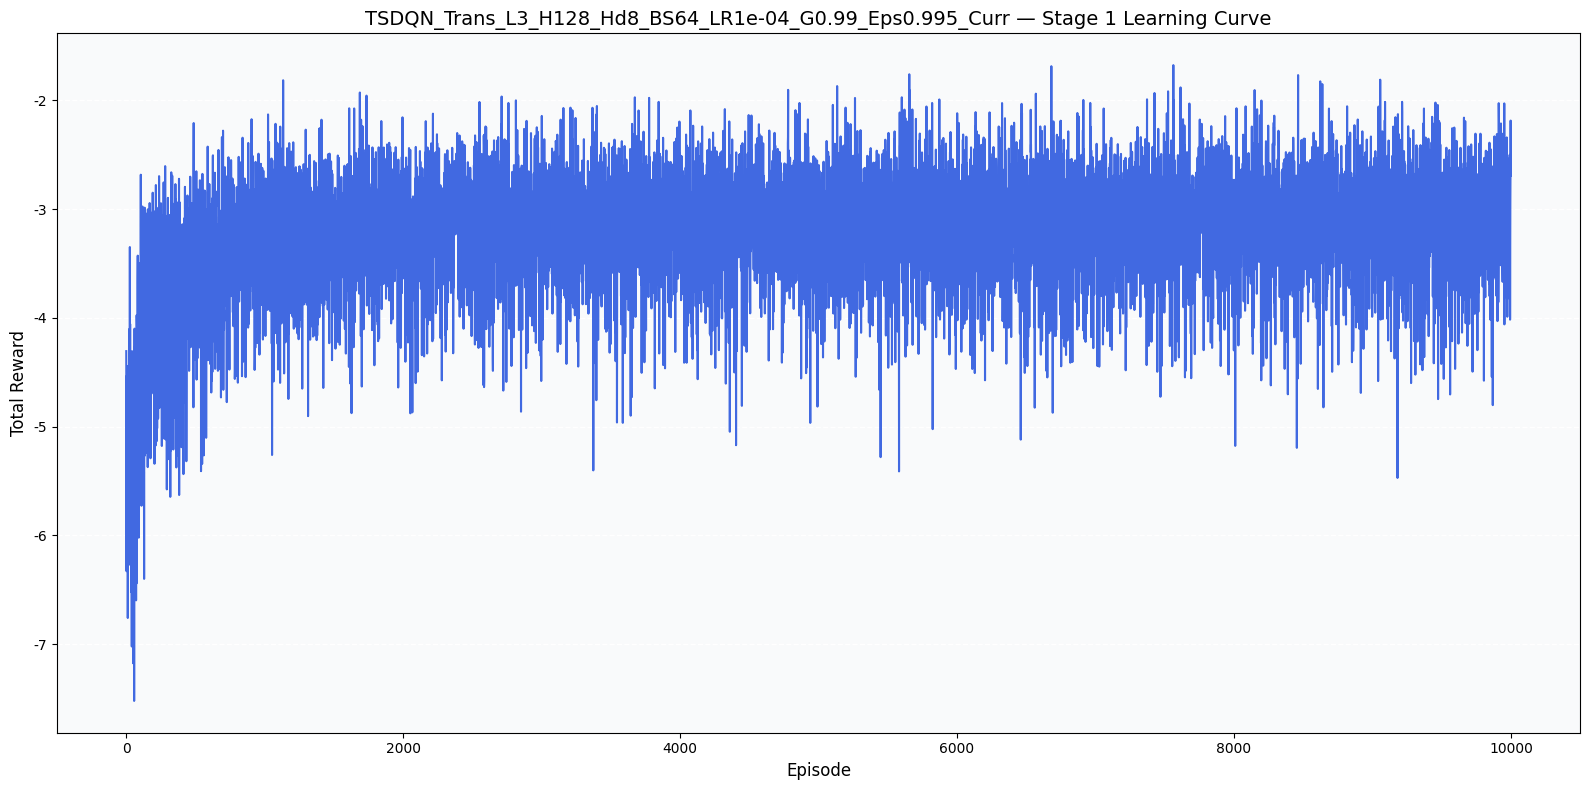

✔ Plotted & saved Stage 1 curve to results\TSDQN_Trans_L3_H128_Hd8_BS64_LR1e-04_G0.99_Eps0.995_Curr_stage1_curve.png



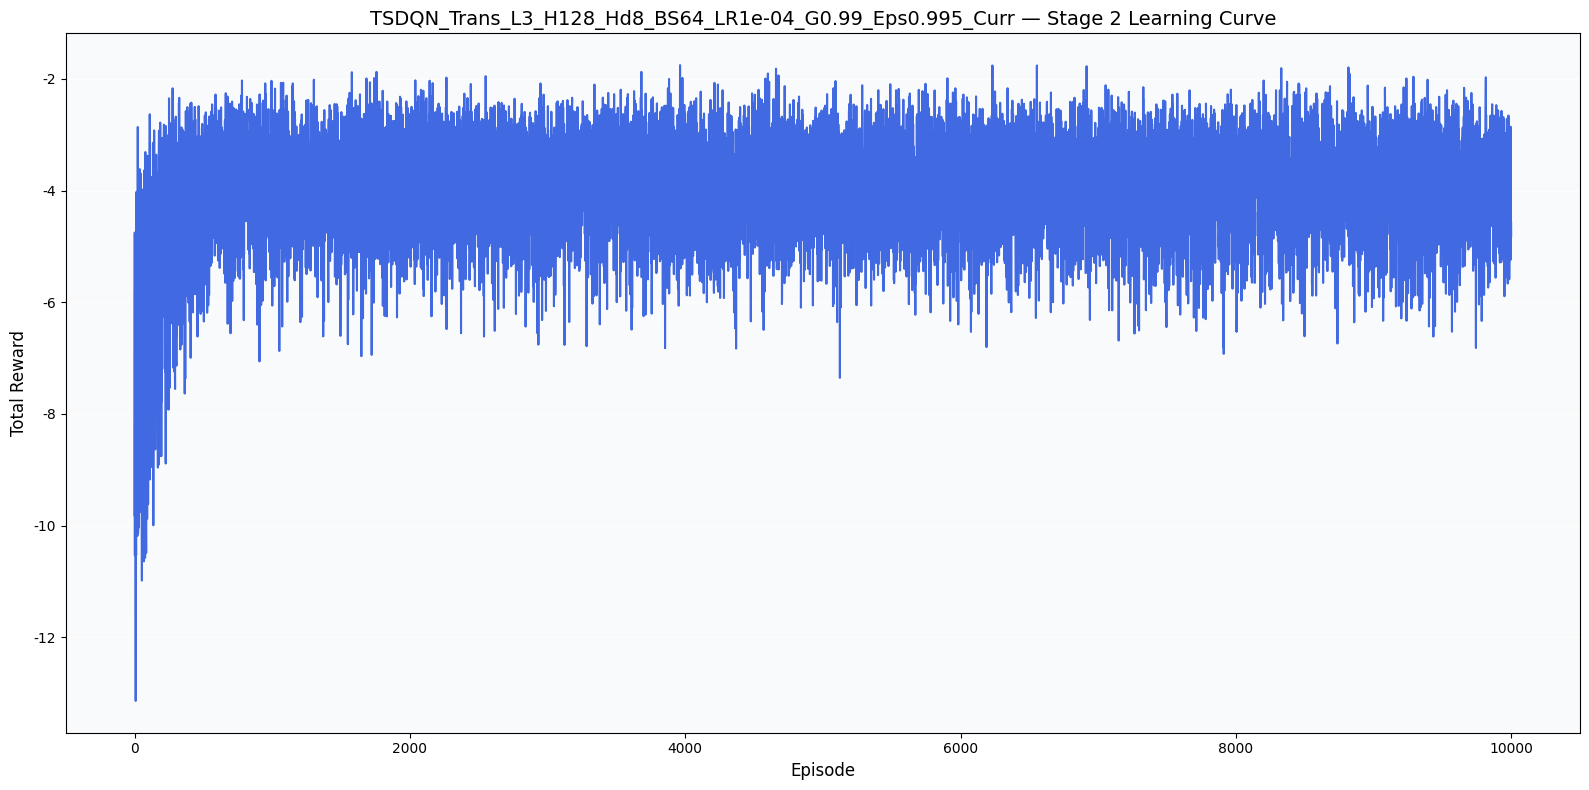

✔ Plotted & saved Stage 2 curve to results\TSDQN_Trans_L3_H128_Hd8_BS64_LR1e-04_G0.99_Eps0.995_Curr_stage2_curve.png



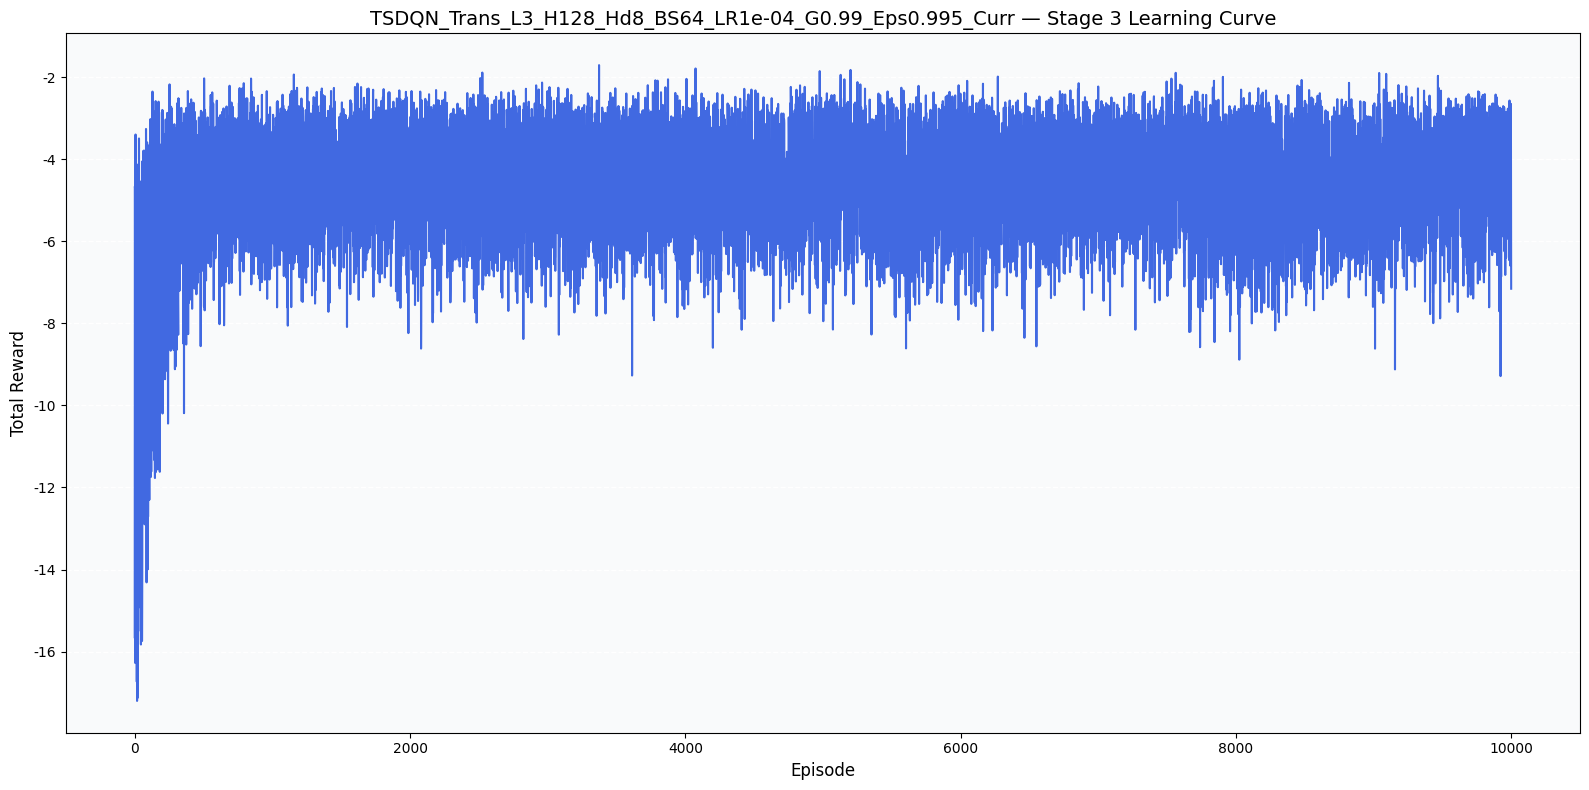

✔ Plotted & saved Stage 3 curve to results\TSDQN_Trans_L3_H128_Hd8_BS64_LR1e-04_G0.99_Eps0.995_Curr_stage3_curve.png



In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# (A) 결과 파일들이 있는 폴더
RESULTS_DIR = "results"

# (B) 본인의 실험 이름(exp_name)만 동일하게 설정
exp_name = "TSDQN_Trans_L3_H128_Hd8_BS64_LR1e-04_G0.99_Eps0.995_Curr"

# (C) 스테이지 개수
num_stages = 3

# (D) 각 스테이지 보상 기록(.npy) 불러와서 플롯
for i in range(1, num_stages+1):
    path = os.path.join(RESULTS_DIR, f"{exp_name}_stage{i}_rewards.npy")
    if not os.path.exists(path):
        print(f"!! File not found: {path}")
        continue

    rewards = np.load(path)  # shape = (episodes,)

    plt.figure(figsize=(16,8))
    sns.lineplot(data=rewards, color='royalblue')
    plt.title(f"{exp_name} — Stage {i} Learning Curve", fontsize=14)
    plt.xlabel("Episode", fontsize=12)
    plt.ylabel("Total Reward", fontsize=12)

    # y축 천 단위 콤마 포맷
    fmt = ticker.FuncFormatter(lambda x, pos: f"{x:,.0f}")
    plt.gca().yaxis.set_major_formatter(fmt)

    # 배경 & 그리드
    plt.gca().set_facecolor('#F9FAFB')
    plt.grid(axis='y', color='white', linestyle='--', linewidth=1)

    # 저장 & 표시
    out_png = os.path.join(RESULTS_DIR, f"{exp_name}_stage{i}_curve.png")
    plt.tight_layout()
    plt.savefig(out_png)
    plt.show()
    print(f"✔ Plotted & saved Stage {i} curve to {out_png}\n")

In [2]:
import os, glob, time, random
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# ─── 하이퍼파라미터(개선) ───────────────────────────────────────────────
EMB_DIM     = 256    # ↑ 표현력 확장
N_HEADS     = 8
N_LAYERS    = 4      # ↑ 더 깊은 Transformer
DROPOUT     = 0.2    # ↑ 과적합 방지
BATCH_SIZE  = 128    # ↑ 배치 크기
LR          = 1e-4
GAMMA       = 0.99
EPS_START   = 1.0
EPS_END     = 0.05
EPS_DECAY   = 0.995
SYNC_STEPS  = 1000   # ↑ 타깃 네트워크 동기화 주기
STAGE_EPS   = 50000  # 단계별 에피소드 수

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}\n")

# ─── 1. 데이터 로드 (각 50k 인스턴스 가정) ─────────────────────────────────
def load_coords(n):
    files = sorted(glob.glob(f"data/TSP{n}/instances/instance_*.npz"))
    # 예: 50 000개라면 glob이 모두 불러옵니다
    return [np.load(f)["coords"].astype(np.float32) for f in files]

train_10 = load_coords(10)
train_20 = load_coords(20)
train_30 = load_coords(30)

# 테스트 5문제(항상 20도시)
def load_test(path="data/homework/hw_2_tsp_20.txt"):
    coords_list, tours = [], []
    with open(path) as f:
        for line in f:
            parts = line.strip().split()
            i = parts.index("output")
            coords = np.array(list(map(float, parts[:i]))).reshape(-1,2).astype(np.float32)
            tour   = [int(x)-1 for x in parts[i+1:]]
            coords_list.append(coords); tours.append(tour)
    return coords_list, tours

test_coords, test_tours = load_test()
print(f"Loaded test {len(test_coords)} instances (20 cities each)\n")

# ─── 2. Token-based Environment (패딩 포함) ─────────────────────────────────
class TSPEnvToken:
    def __init__(self, coords, N_max):
        self.coords = coords
        self.N      = len(coords)
        self.N_max  = N_max
    def reset(self):
        self.visited = np.zeros(self.N, bool)
        self.current = 0
        self.visited[0] = True
        return self._state()
    def _state(self):
        xy      = self.coords
        visited = self.visited.astype(np.float32)[:,None]
        is_cur  = np.eye(self.N, dtype=np.float32)[self.current][:,None]
        tokens  = np.concatenate([xy, visited, is_cur], axis=1)
        if self.N < self.N_max:
            pad = np.zeros((self.N_max-self.N,4),np.float32)
            pad[:,2] = 1.0    # padding은 방문 처리해서 선택 금지
            tokens = np.vstack([tokens, pad])
        return tokens
    def step(self, a):
        prev = self.current
        self.current = a
        self.visited[a] = True
        d = np.linalg.norm(self.coords[prev]-self.coords[a])
        r = -d
        done = bool(self.visited.all())
        if done:
            r -= np.linalg.norm(self.coords[self.current]-self.coords[0])
        return self._state(), r, done, {}

# ─── 3. Transformer-DQN 모델 ───────────────────────────────────────────────
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0)/d_model))
        pe[:,0::2] = torch.sin(pos*div); pe[:,1::2] = torch.cos(pos*div)
        self.register_buffer('pe', pe)
    def forward(self, x):
        return x + self.pe[:x.size(1)].unsqueeze(0)

class TSPTransformerDQN(nn.Module):
    def __init__(self, emb_dim, n_heads, n_layers, dropout, max_len):
        super().__init__()
        self.input_proj = nn.Linear(4, emb_dim)
        self.pos_enc    = PositionalEncoding(emb_dim, max_len)
        layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=n_heads,
                                           dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(layer, n_layers)
        self.q_head  = nn.Linear(emb_dim, 1)
    def forward(self, tokens):
        x = self.input_proj(tokens)
        x = self.pos_enc(x)
        x = self.encoder(x)
        return self.q_head(x).squeeze(-1)

# ─── 4. Replay Buffer & Agent ───────────────────────────────────────────────
class ReplayBuffer:
    def __init__(self, cap=10000):
        self.buf, self.cap = [], cap
    def push(self, *exp):
        if len(self.buf) >= self.cap: self.buf.pop(0)
        self.buf.append(exp)
    def sample(self, B):
        idx = random.sample(range(len(self.buf)), B)
        s,a,r,s2,d = zip(*(self.buf[i] for i in idx))
        return (
            torch.tensor(np.stack(s), dtype=torch.float32, device=DEVICE),
            torch.tensor(a, dtype=torch.long,   device=DEVICE),
            torch.tensor(r, dtype=torch.float32,device=DEVICE),
            torch.tensor(np.stack(s2), dtype=torch.float32,device=DEVICE),
            torch.tensor(d, dtype=torch.float32,device=DEVICE),
        )
    def __len__(self): return len(self.buf)

class DQNAgent:
    def __init__(self, max_len):
        self.net    = TSPTransformerDQN(EMB_DIM,N_HEADS,N_LAYERS,DROPOUT,max_len).to(DEVICE)
        self.target = TSPTransformerDQN(EMB_DIM,N_HEADS,N_LAYERS,DROPOUT,max_len).to(DEVICE)
        self.target.load_state_dict(self.net.state_dict())
        self.opt    = optim.Adam(self.net.parameters(), lr=LR)
        self.buf    = ReplayBuffer()
        self.gamma  = GAMMA
        self.steps  = 0
    def select(self, state, eps):
        feat    = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        visited = state[:,2]
        if random.random() < eps:
            return int(random.choice(np.where(visited==0)[0]))
        with torch.no_grad():
            q = self.net(feat)[0].cpu().numpy()
        q[visited>0] = -np.inf
        return int(np.argmax(q))
    def update(self):
        if len(self.buf) < BATCH_SIZE: return
        s,a,r,s2,d = self.buf.sample(BATCH_SIZE)
        q_s = self.net(s).gather(1,a.unsqueeze(1)).squeeze(1)
        with torch.no_grad():
            q2 = self.target(s2).max(1)[0]
            y  = r + self.gamma*q2*(1-d)
        loss = nn.SmoothL1Loss()(q_s, y)
        self.opt.zero_grad(); loss.backward(); self.opt.step()
        self.steps += 1
        if self.steps % SYNC_STEPS == 0:
            self.target.load_state_dict(self.net.state_dict())

# ─── 5. 커리큘럼 학습 루프(혼합비율 최적화) ────────────────────────────────
curriculum = [
    # 1단계: 10도시만
    ([10],       STAGE_EPS),
    # 2단계: 10 vs 20을 20:80 확률로
    ([10,20],    STAGE_EPS),
    # 3단계: 10/20/30 고르게 (각 1/3)
    ([10,20,30], STAGE_EPS),
]
global_max = max(sz for sizes,_ in curriculum for sz in sizes)  # =30
agent = None
history_all = []
t_total = time.time()

for stage,(sizes, eps_cnt) in enumerate(curriculum, start=1):
    print(f"\n--- Stage {stage}: sizes={sizes}, episodes={eps_cnt} ---")
    # sync + clear buffer
    if agent:
        agent.target.load_state_dict(agent.net.state_dict())
        agent.buf.buf.clear()
    else:
        agent = DQNAgent(global_max)

    # 풀 선택 로직: stage2만 비율 조정
    def sample_env():
        if sizes == [10,20]:
            # 20% 확률로 10도시, 80% 확률로 20도시
            return random.choice(train_10) if random.random()<0.2 else random.choice(train_20)
        elif sizes == [10,20,30]:
            # 균등하게 섞음
            choice_list = [train_10, train_20, train_30]
            return random.choice(random.choice(choice_list))
        else:
            return random.choice(train_10)

    eps = EPS_START
    hist = []
    t0 = time.time()

    for ep in range(1, eps_cnt+1):
        coords = sample_env()
        env    = TSPEnvToken(coords, N_max=global_max)
        s = env.reset(); done=False; tot_r=0.0

        while not done:
            a = agent.select(s, eps)
            s2, r, done, _ = env.step(a)
            tot_r += r
            agent.buf.push(s,a,r,s2,float(done))
            s = s2
            agent.update()

        hist.append(tot_r)
        eps = max(EPS_END, eps*EPS_DECAY)

        if ep==1 or ep%1000==0:
            avg100 = np.mean(hist[-100:]) if len(hist)>=100 else hist[-1]
            print(f"Ep {ep:5d}/{eps_cnt}  ε={eps:.3f}  avg100={avg100:6.2f}  stage_time={time.time()-t0:5.1f}s")

    history_all.append(hist)
    print(f"Stage {stage} done in {time.time()-t0:.1f}s")

print(f"\nTotal curriculum training time: {time.time()-t_total:.1f}s\n")

# ─── 6. 테스트 (20도시 5문제) ───────────────────────────────────────────────
print("=== Test on 5 Instances (20 cities) ===")
for idx,(coords,tour) in enumerate(zip(test_coords,test_tours), start=1):
    env   = TSPEnvToken(coords, N_max=global_max)
    s     = env.reset(); done=False; route=[0]
    while not done:
        a = agent.select(s, eps=0.0)
        s,_,done,_ = env.step(a); route.append(a)
    route.append(0)
    opt_cycle = tour+[tour[0]]
    opt_cost  = sum(np.linalg.norm(coords[u]-coords[v]) for u,v in zip(opt_cycle[:-1],opt_cycle[1:]))
    dqn_cost  = sum(np.linalg.norm(coords[route[i]]-coords[route[i+1]]) for i in range(len(route)-1))
    gap = (dqn_cost-opt_cost)/opt_cost*100
    print(f"\n-- Test {idx} --")
    print("Opt route =", [n+1 for n in opt_cycle])
    print("DQN route =", [n+1 for n in route])
    print(f"Opt cost = {opt_cost:.4f}, DQN cost = {dqn_cost:.4f}, Gap%={gap:.2f}%")

Using device: cuda

Loaded test 5 instances (20 cities each)


--- Stage 1: sizes=[10], episodes=50000 ---
Ep     1/50000  ε=0.995  avg100= -6.42  stage_time=  0.0s
Ep  1000/50000  ε=0.050  avg100= -3.51  stage_time=225.5s
Ep  2000/50000  ε=0.050  avg100= -3.26  stage_time=458.2s
Ep  3000/50000  ε=0.050  avg100= -3.20  stage_time=690.9s
Ep  4000/50000  ε=0.050  avg100= -3.17  stage_time=923.1s
Ep  5000/50000  ε=0.050  avg100= -3.12  stage_time=1155.6s
Ep  6000/50000  ε=0.050  avg100= -3.09  stage_time=1387.5s
Ep  7000/50000  ε=0.050  avg100= -3.09  stage_time=1618.7s
Ep  8000/50000  ε=0.050  avg100= -3.13  stage_time=1849.8s
Ep  9000/50000  ε=0.050  avg100= -3.12  stage_time=2081.0s
Ep 10000/50000  ε=0.050  avg100= -3.15  stage_time=2313.6s
Ep 11000/50000  ε=0.050  avg100= -3.09  stage_time=2545.4s
Ep 12000/50000  ε=0.050  avg100= -3.16  stage_time=2776.7s
Ep 13000/50000  ε=0.050  avg100= -3.05  stage_time=3007.9s
Ep 14000/50000  ε=0.050  avg100= -3.10  stage_time=3239.3s
Ep 15000/5000

In [3]:

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# ─── A) 결과 디렉터리 & 실험 이름 설정 ────────────────────────────────────
results_dir = "results"
exp_name    = "TSDQN_Trans_L4_E256_Dr0.2_Curr"   # 학습 스크립트와 일치시켜 주세요

# ─── B) 스테이지 수만큼 .npy 파일 로드 & 플롯 ─────────────────────────────
# 예: Stage1 ~ Stage3 까지
num_stages = 3
for stage in range(1, num_stages+1):
    rewards_path = os.path.join(results_dir, f"{exp_name}_stage{stage}_rewards.npy")
    if not os.path.isfile(rewards_path):
        print(f"⚠️ 파일 없음: {rewards_path}")
        continue

    # 보상 기록 로드
    history = np.load(rewards_path)

    # 러닝 커브 플롯
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=history, color='royalblue')
    plt.title(f"{exp_name} Stage {stage} Learning Curve", fontsize=14)
    plt.xlabel("Episode", fontsize=12)
    plt.ylabel("Total Reward", fontsize=12)
    fmt = ticker.FuncFormatter(lambda x, pos: f"{int(x):,}")
    plt.gca().yaxis.set_major_formatter(fmt)
    plt.grid(axis='y', linestyle='--', color='lightgray')

    # 저장 및 표시
    out_png = os.path.join(results_dir, f"{exp_name}_stage{stage}_curve.png")
    plt.tight_layout()
    plt.savefig(out_png)
    plt.close()
    print(f"✔ Stage{stage} curve saved to {out_png}")

⚠️ 파일 없음: results\TSDQN_Trans_L4_E256_Dr0.2_Curr_stage1_rewards.npy
⚠️ 파일 없음: results\TSDQN_Trans_L4_E256_Dr0.2_Curr_stage2_rewards.npy
⚠️ 파일 없음: results\TSDQN_Trans_L4_E256_Dr0.2_Curr_stage3_rewards.npy


### Transformer Encoder + Decoder

In [3]:
import os, glob, time, random
import numpy as np
import torch, torch.nn as nn, torch.optim as optim

# ─── 하이퍼파라미터 ─────────────────────────────────────────────────────────
EMB_DIM    = 128
N_HEADS    = 8
N_LAYERS   = 3
DROPOUT    = 0.1
BATCH_SIZE = 64
LR         = 1e-4
GAMMA      = 0.99
EPS_START  = 1.0
EPS_END    = 0.05
EPS_DECAY  = 0.995
SYNC_STEPS = 500
STAGE_EPS  = 10000   # 각 단계 에피소드 수

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}\n")

# ─── 테스트 데이터 로드 ───────────────────────────────────────────────────────
def load_test(path="data/homework/hw_2_tsp_20.txt"):
    coords_list, tours = [], []
    with open(path) as f:
        for line in f:
            parts = line.strip().split(); i = parts.index("output")
            vals = list(map(float, parts[:i]))
            tour = [int(x)-1 for x in parts[i+1:]]
            coords_list.append(np.array(vals, dtype=np.float32).reshape(-1,2))
            tours.append(tour)
    return coords_list, tours

test_coords, test_tours = load_test()
print(f"Loaded test {len(test_coords)} instances (20 cities each)\n")

# ─── 커리큘럼 정의 ─────────────────────────────────────────────────────────
curriculum = [
    ([10],         STAGE_EPS),
    ([10, 20],     STAGE_EPS),
    ([10, 20, 30], STAGE_EPS),
]
GLOBAL_MAX = max(sz for sizes, _ in curriculum for sz in sizes)

# ─── 1. 훈련 데이터 로드 ─────────────────────────────────────────────────────
def load_coords(n):
    files = sorted(glob.glob(f"data/TSP{n}/instances/instance_*.npz"))
    return [np.load(f)["coords"].astype(np.float32) for f in files]

# ─── 2. Token-based Env ───────────────────────────────────────────────────────
class TSPEnvToken:
    def __init__(self, coords, N_max):
        self.coords = coords; self.N = len(coords); self.N_max = N_max
    def reset(self):
        self.visited = np.zeros(self.N, bool)
        self.current = 0; self.visited[0] = True
        return self._state()
    def _state(self):
        xy      = self.coords.astype(np.float32)
        visited = self.visited.astype(np.float32)[:,None]
        is_cur  = np.eye(self.N, dtype=np.float32)[self.current][:,None]
        toks    = np.concatenate([xy, visited, is_cur], axis=1)
        if self.N < self.N_max:
            pad = np.zeros((self.N_max-self.N, 4), np.float32)
            pad[:,2] = 1.0
            toks = np.vstack([toks, pad])
        return toks
    def step(self, a):
        prev, self.current = self.current, a
        self.visited[a] = True
        d = np.linalg.norm(self.coords[prev]-self.coords[a])
        r = -d
        done = bool(self.visited.all())
        if done:
            r -= np.linalg.norm(self.coords[self.current]-self.coords[0])
        return self._state(), r, done, {}

# ─── 3. Transformer-DQN ─────────────────────────────────────────────────────
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float()*-(np.log(10000.)/d_model))
        pe[:,0::2] = torch.sin(pos*div); pe[:,1::2] = torch.cos(pos*div)
        self.register_buffer('pe', pe)
    def forward(self, x):
        return x + self.pe[:x.size(1)].unsqueeze(0)

class TSPTransformerDQN(nn.Module):
    def __init__(self, emb, heads, layers, drop, max_len):
        super().__init__()
        self.input_proj = nn.Linear(4, emb)
        self.pos_enc    = PositionalEncoding(emb, max_len)
        layer = nn.TransformerEncoderLayer(d_model=emb, nhead=heads,
                                           dropout=drop, batch_first=True)
        self.encoder = nn.TransformerEncoder(layer, layers)
        self.q_head  = nn.Linear(emb, 1)
    def forward(self, x):
        x = self.input_proj(x); x = self.pos_enc(x)
        x = self.encoder(x)
        return self.q_head(x).squeeze(-1)

# ─── 4. Buffer & Agent ───────────────────────────────────────────────────────
class ReplayBuffer:
    def __init__(self, cap=10000): self.buf, self.cap = [], cap
    def push(self,*e):
        if len(self.buf)>=self.cap: self.buf.pop(0)
        self.buf.append(e)
    def sample(self,B):
        idx = random.sample(range(len(self.buf)), B)
        s,a,r,s2,d = zip(*(self.buf[i] for i in idx))
        return (
          torch.tensor(np.stack(s),   device=DEVICE),
          torch.tensor(a, dtype=torch.long,   device=DEVICE),
          torch.tensor(r, dtype=torch.float32,device=DEVICE),
          torch.tensor(np.stack(s2), device=DEVICE),
          torch.tensor(d, dtype=torch.float32,device=DEVICE),
        )
    def __len__(self): return len(self.buf)

class DQNAgent:
    def __init__(self, max_len):
        self.net    = TSPTransformerDQN(EMB_DIM,N_HEADS,N_LAYERS,DROPOUT,max_len).to(DEVICE)
        self.target = TSPTransformerDQN(EMB_DIM,N_HEADS,N_LAYERS,DROPOUT,max_len).to(DEVICE)
        self.target.load_state_dict(self.net.state_dict())
        self.opt    = optim.Adam(self.net.parameters(), lr=LR)
        self.buf    = ReplayBuffer()
        self.gamma  = GAMMA
        self.steps  = 0

    def select(self, state, eps):
        feat    = torch.tensor(state, device=DEVICE).unsqueeze(0)
        visited = state[:,2]
        if random.random()<eps:
            return int(random.choice(np.where(visited==0)[0]))
        with torch.no_grad():
            q = self.net(feat)[0].cpu().numpy()
        q[visited>0] = -np.inf
        return int(np.argmax(q))

    def update(self):
        if len(self.buf)<BATCH_SIZE: return
        s,a,r,s2,d = self.buf.sample(BATCH_SIZE)
        q_s = self.net(s).gather(1,a.unsqueeze(1)).squeeze(1)
        with torch.no_grad():
            q2 = self.target(s2).max(1)[0]
            y  = r + self.gamma*q2*(1-d)
        loss = nn.SmoothL1Loss()(q_s, y)
        self.opt.zero_grad(); loss.backward(); self.opt.step()
        self.steps+=1
        if self.steps%SYNC_STEPS==0:
            self.target.load_state_dict(self.net.state_dict())

# ─── 5. 커리큘럼 학습 ───────────────────────────────────────────────────────
agent = DQNAgent(GLOBAL_MAX)
history_all = []
t_all = time.time()

for stage,(sizes, eps_cnt) in enumerate(curriculum, start=1):
    print(f"\n--- Stage{stage}: sizes={sizes}, episodes={eps_cnt} ---")
    # (a) sync & clear buffer
    agent.target.load_state_dict(agent.net.state_dict())
    agent.buf.buf.clear()

    # (b) build pool
    pool = sum((load_coords(n) for n in sizes), [])

    eps = EPS_START
    stage_hist = []
    t0 = time.time()
    for ep in range(1, eps_cnt+1):
        coords = random.choice(pool)
        env    = TSPEnvToken(coords, N_max=GLOBAL_MAX)
        s, done = env.reset(), False
        tot_r = 0.0

        while not done:
            a = agent.select(s, eps)
            s2,r,done,_ = env.step(a)
            tot_r += r
            agent.buf.push(s,a,r,s2,float(done))
            s = s2
            agent.update()

        stage_hist.append(tot_r)
        eps = max(EPS_END, eps*EPS_DECAY)

        # 로그 출력
        if ep==1 or ep%1000==0:
            avg100 = np.mean(stage_hist[-100:]) if len(stage_hist)>=100 else stage_hist[-1]
            print(f"Ep {ep:5d}/{eps_cnt}  ε={eps:.3f}  avg100={avg100:6.2f}  elapsed={time.time()-t0:5.1f}s")

    history_all.append(stage_hist)
    print(f"Stage{stage} completed in {time.time()-t0:.1f}s")

print(f"\nTotal training time: {time.time()-t_all:.1f}s\n")

# ─── 6. 테스트 ───────────────────────────────────────────────────────────────
print("=== Test on 5 Instances (20 cities) ===")
for idx,(coords,tour) in enumerate(zip(test_coords,test_tours),start=1):
    env   = TSPEnvToken(coords, N_max=GLOBAL_MAX)
    s     = env.reset(); done=False; route=[0]
    while not done:
        a = agent.select(s, eps=0.0)
        s,_,done,_ = env.step(a); route.append(a)
    route.append(0)
    opt_cycle = tour+[tour[0]]
    opt_cost  = sum(np.linalg.norm(coords[u]-coords[v])
                    for u,v in zip(opt_cycle[:-1],opt_cycle[1:]))
    dqn_cost = sum(np.linalg.norm(coords[route[i]]-coords[route[i+1]])
                   for i in range(len(route)-1))
    gap = (dqn_cost-opt_cost)/opt_cost*100
    print(f"\n-- Test {idx} --")
    print("Opt route =", [n+1 for n in opt_cycle])
    print("DQN route =", [n+1 for n in route])
    print(f"Opt cost = {opt_cost:.4f}, DQN cost = {dqn_cost:.4f}, Gap%={gap:.2f}%")

# ─── 7. 결과 저장 ───────────────────────────────────────────────────────────
exp_name = f"TSDQN_L{N_LAYERS}_H{EMB_DIM}_Curr"
os.makedirs("results", exist_ok=True)
for i, hist in enumerate(history_all, start=1):
    np.save(f"results/{exp_name}_stage{i}_rewards.npy",
            np.array(hist, dtype=np.float32))
torch.save(agent.net.state_dict(),
           f"results/{exp_name}_model.pth")
print("✔ All results saved under 'results/'")


Using device: cuda

Loaded test 5 instances (20 cities each)


--- Stage1: sizes=[10], episodes=3000 ---
Ep     1/3000  ε=0.995  avg100= -6.39  elapsed=  0.0s
Ep  1000/3000  ε=0.050  avg100= -3.46  elapsed= 94.1s
Ep  2000/3000  ε=0.050  avg100= -3.26  elapsed=192.3s
Ep  3000/3000  ε=0.050  avg100= -3.28  elapsed=289.7s
Stage1 completed in 289.7s

--- Stage2: sizes=[10, 20], episodes=3000 ---
Ep     1/3000  ε=0.995  avg100=-10.83  elapsed=  0.0s
Ep  1000/3000  ε=0.050  avg100= -4.04  elapsed=147.5s
Ep  2000/3000  ε=0.050  avg100= -4.00  elapsed=302.0s
Ep  3000/3000  ε=0.050  avg100= -4.13  elapsed=459.4s
Stage2 completed in 459.4s

--- Stage3: sizes=[10, 20, 30], episodes=3000 ---
Ep     1/3000  ε=0.995  avg100=-18.21  elapsed=  0.0s
Ep  1000/3000  ε=0.050  avg100= -4.76  elapsed=199.6s
Ep  2000/3000  ε=0.050  avg100= -4.61  elapsed=407.8s
Ep  3000/3000  ε=0.050  avg100= -4.71  elapsed=620.8s
Stage3 completed in 620.8s

Total training time: 2047.2s

=== Test on 5 Instances (20 cities) =

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

RESULTS_DIR = "results"
exp_name    = "TSDQN_L3_H128_Curr"   # ── (7)에서 사용한 동일한 이름
num_stages  = 3                      # 위 예제는 스테이지1 ([20]만) 만 실행

for i in range(1, num_stages+1):
    path = os.path.join(RESULTS_DIR, f"stage{i}_rewards.npy")
    if not os.path.exists(path):
        print(f"!! File not found: {path}")
        continue

    rewards = np.load(path)

    plt.figure(figsize=(12,6))
    sns.lineplot(data=rewards, color='royalblue')
    plt.title(f"{exp_name} — Stage {i} Learning Curve", fontsize=14)
    plt.xlabel("Episode", fontsize=12)
    plt.ylabel("Total Reward", fontsize=12)

    fmt = ticker.FuncFormatter(lambda x, pos: f"{x:,.0f}")
    plt.gca().yaxis.set_major_formatter(fmt)
    plt.gca().set_facecolor('#F9FAFB')
    plt.grid(axis='y', linestyle='--', color='lightgray')

    out_png = os.path.join(RESULTS_DIR, f"{exp_name}_stage{i}_curve.png")
    plt.tight_layout()
    plt.savefig(out_png)
    plt.show()
    print(f"✔ Saved plot to {out_png}\n")

!! File not found: results\stage1_rewards.npy
!! File not found: results\stage2_rewards.npy
!! File not found: results\stage3_rewards.npy
